# Demo the models | See them in-action


In [1]:
import sys
import os
sys.path.append("../")

if "notebook" in os.getcwd():
    os.chdir("../")

### Set model type and checkpoint in below cell

In [2]:
import torch
import numpy as np

from src.models.waveform.cicada_clean_unet_att import CicadaCleanUNetModel
from src.models.waveform.cicada_unet_att import CicadaUNetAttModel
from src.models.waveform.cicada_unet import CicadaUNetModel

from torch.utils.data import DataLoader, random_split
from src.data.waveform_data import WaveformDataset
import matplotlib.pyplot as plt
import IPython.display as ipd
from scipy.io.wavfile import write

batch_size = 32

NOISY_WAVE_PATH = "data/processed/28spk/combined_noisy_waves.pt"
CLEAN_WAVE_PATH = "data/processed/28spk/combined_clean_waves.pt"
SR = 48000
SAMPLE_COUNT = 262144

torch.manual_seed(42) #Consistent results

device = "cuda" if torch.cuda.is_available() else "cpu"

MODEL_CKPT = "ckpts/cicadence_unet_clean_final.pt"
model = CicadaCleanUNetModel()
model.load_state_dict(torch.load(MODEL_CKPT, map_location=device))
model.eval()

ENCODERS: 7
S and K [1, 10, 13, 23, 44, 87, 167, 332], [3, 3, 3, 3, 3, 3, 3]
Att Heads: 4
Hidden Channels: 0.7
DROPOUT: 0.3483700736541754


CicadaCleanUNetModel(
  (encoders): ModuleList(
    (0): Sequential(
      (0): Conv1d(1, 10, kernel_size=(3,), stride=(2,), padding=(1,))
      (1): ReLU()
      (2): Conv1d(10, 20, kernel_size=(1,), stride=(1,))
      (3): GLU(dim=1)
    )
    (1): Sequential(
      (0): Conv1d(10, 13, kernel_size=(3,), stride=(2,), padding=(1,))
      (1): ReLU()
      (2): Conv1d(13, 26, kernel_size=(1,), stride=(1,))
      (3): GLU(dim=1)
    )
    (2): Sequential(
      (0): Conv1d(13, 23, kernel_size=(3,), stride=(2,), padding=(1,))
      (1): ReLU()
      (2): Conv1d(23, 46, kernel_size=(1,), stride=(1,))
      (3): GLU(dim=1)
    )
    (3): Sequential(
      (0): Conv1d(23, 44, kernel_size=(3,), stride=(2,), padding=(1,))
      (1): ReLU()
      (2): Conv1d(44, 88, kernel_size=(1,), stride=(1,))
      (3): GLU(dim=1)
    )
    (4): Sequential(
      (0): Conv1d(44, 87, kernel_size=(3,), stride=(2,), padding=(1,))
      (1): ReLU()
      (2): Conv1d(87, 174, kernel_size=(1,), stride=(1,))
     

In [3]:
data = WaveformDataset(NOISY_WAVE_PATH, CLEAN_WAVE_PATH)

In [4]:
noisy_sample, clean_sample = data[0]
print(noisy_sample.shape)

torch.Size([1, 262144])


In [5]:
# Select a single sample from the batch
noisy_np = noisy_sample.squeeze().cpu().numpy()
clean_np = clean_sample.squeeze().cpu().numpy()

In [6]:
target = noisy_sample.reshape(1, 1, -1)
waveProcessed = model(target).detach().squeeze()
print(waveProcessed.shape)

torch.Size([262144])


### Show Noisy (Red) vs. Model Cleaned (Blue) Waveforms Side-by-side

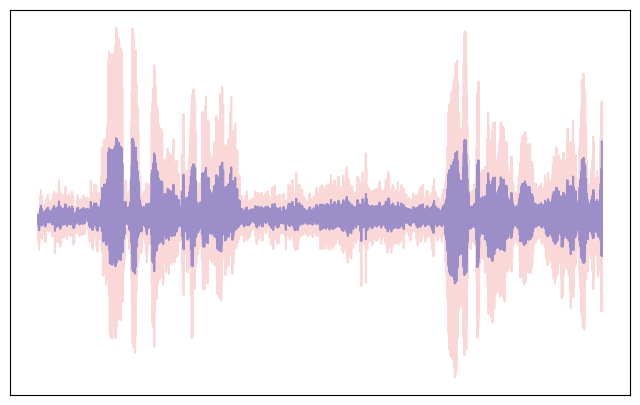

In [7]:
duration = SAMPLE_COUNT / SR  # seconds
t = np.linspace(0, duration, SAMPLE_COUNT, endpoint=False)  # Time array
plt.figure(figsize=(8, 5), facecolor='none')  # Transparent figure background
ax = plt.gca()
ax.set_facecolor('none') 
plt.plot(t, waveProcessed, alpha=0.7, color="royalblue")
plt.plot(t, noisy_np, alpha=0.3, color="lightcoral")
plt.xticks([])
plt.yticks([])
# plt.savefig("examples/waveforms/unet_clean_waveform.png", dpi=300, bbox_inches='tight', transparent=True)  
plt.show()


In [8]:
# Uncomment below to save audio sample if you want
# write('examples/audio_samples/unet_clean.wav', SR, waveProcessed.numpy())  # (filename, sample rate, data)

In [9]:
ipd.Audio(clean_np, rate=SR) # Clean Audio Sample

In [10]:
ipd.Audio(noisy_np, rate=SR) # Noisy Audio Sample

In [11]:
ipd.Audio(waveProcessed.numpy(), rate=SR) # Model-Processed Audio Sample